# Install Pytorch, Torchvision

In [ ]:
#!pip install -U torch torchvision
#!pip install git+https://github.com/facebookresearch/fvcore.git
#import torch, torchvision
#torch.__version__

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 13.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 4.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=056c5211eaee3a617e5d51a290c2a7

# Install Detectron2

In [ ]:
#!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
#!pip install -e detectron2_repo

In [ ]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 754 kB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=a0e653ea697bfe49a3c38a3708b2ebeb220c47aadbbefe8636bfcd090eb824ae
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built fvcore


# Import

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train with COCO dataset

In [ ]:
# Grant access to google drive.
# Run this cell, then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit Enter

import os
from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder
# os.chdir('/content/gdrive/My Drive/Your Folder Name/Your sub Folder Name')
os.chdir('/content/gdrive/My Drive/detectron')
!ls

Mounted at /content/gdrive
coco_test  coco_train  coco_validate  output


Register the tools dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("tools", {}, "coco_train/labels.json", "coco_train/data")

In [ ]:
tools_metadata = MetadataCatalog.get("tools")
dataset_dicts = DatasetCatalog.get("tools")

[11/10 01:57:23 d2.data.datasets.coco]: Loading coco_train/labels.json takes 1.23 seconds.
WARNING [11/10 01:57:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/10 01:57:23 d2.data.datasets.coco]: Loaded 4411 images in COCO format from coco_train/labels.json


In [ ]:
register_coco_instances("test_tools", {}, "coco_validate/labels.json", "coco_validate/data")
test_tools_metadata = MetadataCatalog.get("test_tools")
test_dataset_dicts = DatasetCatalog.get("test_tools")

WARNING [11/10 01:57:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/10 01:57:24 d2.data.datasets.coco]: Loaded 801 images in COCO format from coco_validate/labels.json


Visualising annotations of random training set to verify imported dataset

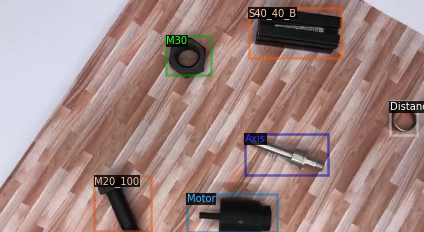

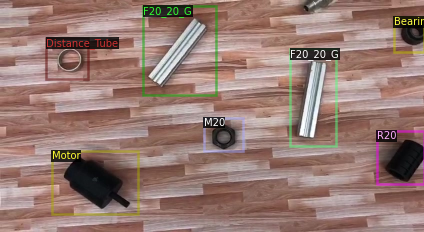

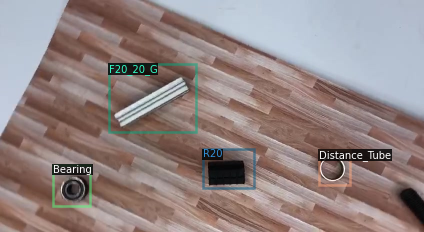

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tools_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator 
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

Train model with coco pretrained faster rcnn.
Tune hyper parameters


In [ ]:
!rm ./output/metrics.json

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("tools",)
#cfg.DATASETS.TEST = ()
cfg.DATASETS.TEST = ("test_tools",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14    # 1 more to include super category "Defect"
cfg.TEST.EVAL_PERIOD = 20

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/10 01:57:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:12, 33.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box

[11/10 01:58:12 d2.engine.train_loop]: Starting training from iteration 0
WARNING [11/10 01:59:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/10 01:59:29 d2.data.datasets.coco]: Loaded 801 images in COCO format from coco_validate/labels.json
[11/10 01:59:29 d2.data.common]: Serializing 801 elements to byte tensors and concatenating them all ...
[11/10 01:59:29 d2.data.common]: Serialized dataset takes 0.47 MiB
[11/10 01:59:29 d2.evaluation.evaluator]: Start inference on 801 images
[11/10 01:59:45 d2.evaluation.evaluator]: Inference done 11/801. 0.7628 s / img. ETA=0:10:04
[11/10 01:59:51 d2.evaluation.evaluator]: Inference done 18/801. 0.7614 s / img. ETA=0:09:58
[11/10 01:59:56 d2.evaluation.evaluator]: Inference done 25/801. 0.7605 s / img. ETA=0:09:52
[11/10 02:00:01 d2.evaluation.evaluator]: Inference done 32/801. 0.7604 s / img. ETA=0:09:47
[11/10 02:00:07 d2.evaluation.evaluator]: Inference done 39/801. 0.7

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

experiment_metrics

[{'bbox/AP': 0.5396828129092569,
  'bbox/AP-Axis': 0.0,
  'bbox/AP-Bearing': 1.179656111202399,
  'bbox/AP-Bearing_Box': 0.2187479435637484,
  'bbox/AP-Defect': nan,
  'bbox/AP-Distance_Tube': 1.481866091614056,
  'bbox/AP-F20_20_B': 0.006463290057765615,
  'bbox/AP-F20_20_G': 0.0,
  'bbox/AP-M20': 0.6630046237086457,
  'bbox/AP-M20_100': 0.001570805539033427,
  'bbox/AP-M30': 0.1513366825561457,
  'bbox/AP-Motor': 0.0002303627291533248,
  'bbox/AP-R20': 3.278557173271377,
  'bbox/AP-S40_40_B': 0.010899833579686756,
  'bbox/AP-S40_40_G': 0.023543649998329433,
  'bbox/AP50': 1.6827152081558143,
  'bbox/AP75': 0.2621815796157434,
  'bbox/APl': 0.6147235259329882,
  'bbox/APm': 0.8245550890904287,
  'bbox/APs': 0.0,
  'data_time': 0.006585255499999221,
  'eta_seconds': 312.70349108699986,
  'fast_rcnn/cls_accuracy': 0.75,
  'fast_rcnn/false_negative': 1.0,
  'fast_rcnn/fg_cls_accuracy': 0.0,
  'iteration': 19,
  'loss_box_reg': 0.9044631719589233,
  'loss_cls': 1.9579440355300903,
  'loss

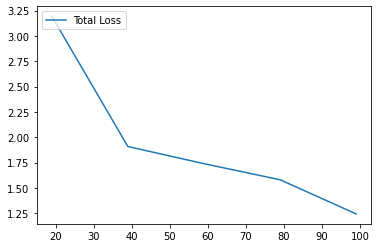

In [ ]:
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
#plt.plot(
#    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
#    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
#plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.legend(['Total Loss'], loc='upper left')
plt.show()

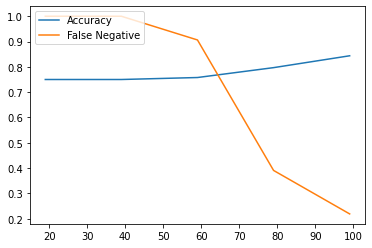

In [ ]:
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'fast_rcnn/cls_accuracy' in x], 
    [x['fast_rcnn/cls_accuracy'] for x in experiment_metrics if 'fast_rcnn/cls_accuracy' in x])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'fast_rcnn/cls_accuracy' in x], 
    [x['fast_rcnn/false_negative'] for x in experiment_metrics if 'fast_rcnn/cls_accuracy' in x])
plt.legend(['Accuracy', 'False Negative'], loc='upper left')
plt.show()

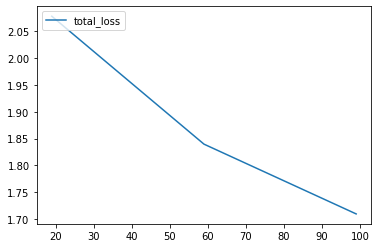

In [ ]:
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')

# Load trained model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model (Any confidence level that is >= 50% will show)
cfg.DATASETS.TEST = ("tools", )
predictor = DefaultPredictor(cfg)

# Testing
First test with training set with color modification. (We can use this to do data augmentation)

In [ ]:
#from detectron2.utils.visualizer import ColorMode
#
#for d in random.sample(dataset_dicts, 3):    
#    im = cv2.imread(d["file_name"])
#    outputs = predictor(im)
#    v = Visualizer(im[:, :, ::-1],
#                   metadata=tools_metadata, 
#                   scale=0.8, 
#                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
#    )
#    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
tools_metadata

Metadata(evaluator_type='coco', image_root='coco_train/data', json_file='coco_train/labels.json', name='tools', thing_classes=['Defect', 'Axis', 'Bearing', 'Bearing_Box', 'Distance_Tube', 'F20_20_B', 'F20_20_G', 'S40_40_B', 'S40_40_G', 'Motor', 'M20', 'M30', 'M20_100', 'R20'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13})

Then we test using testing dataset

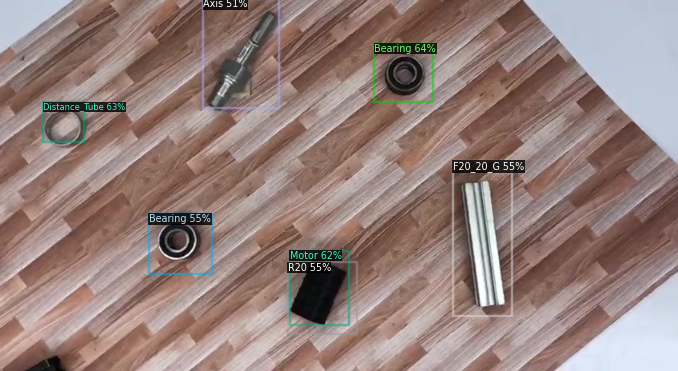

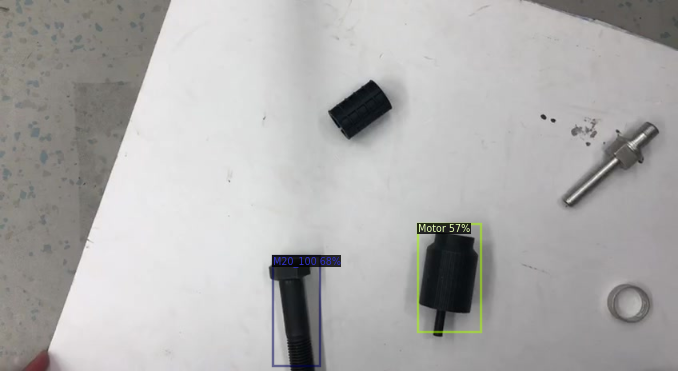

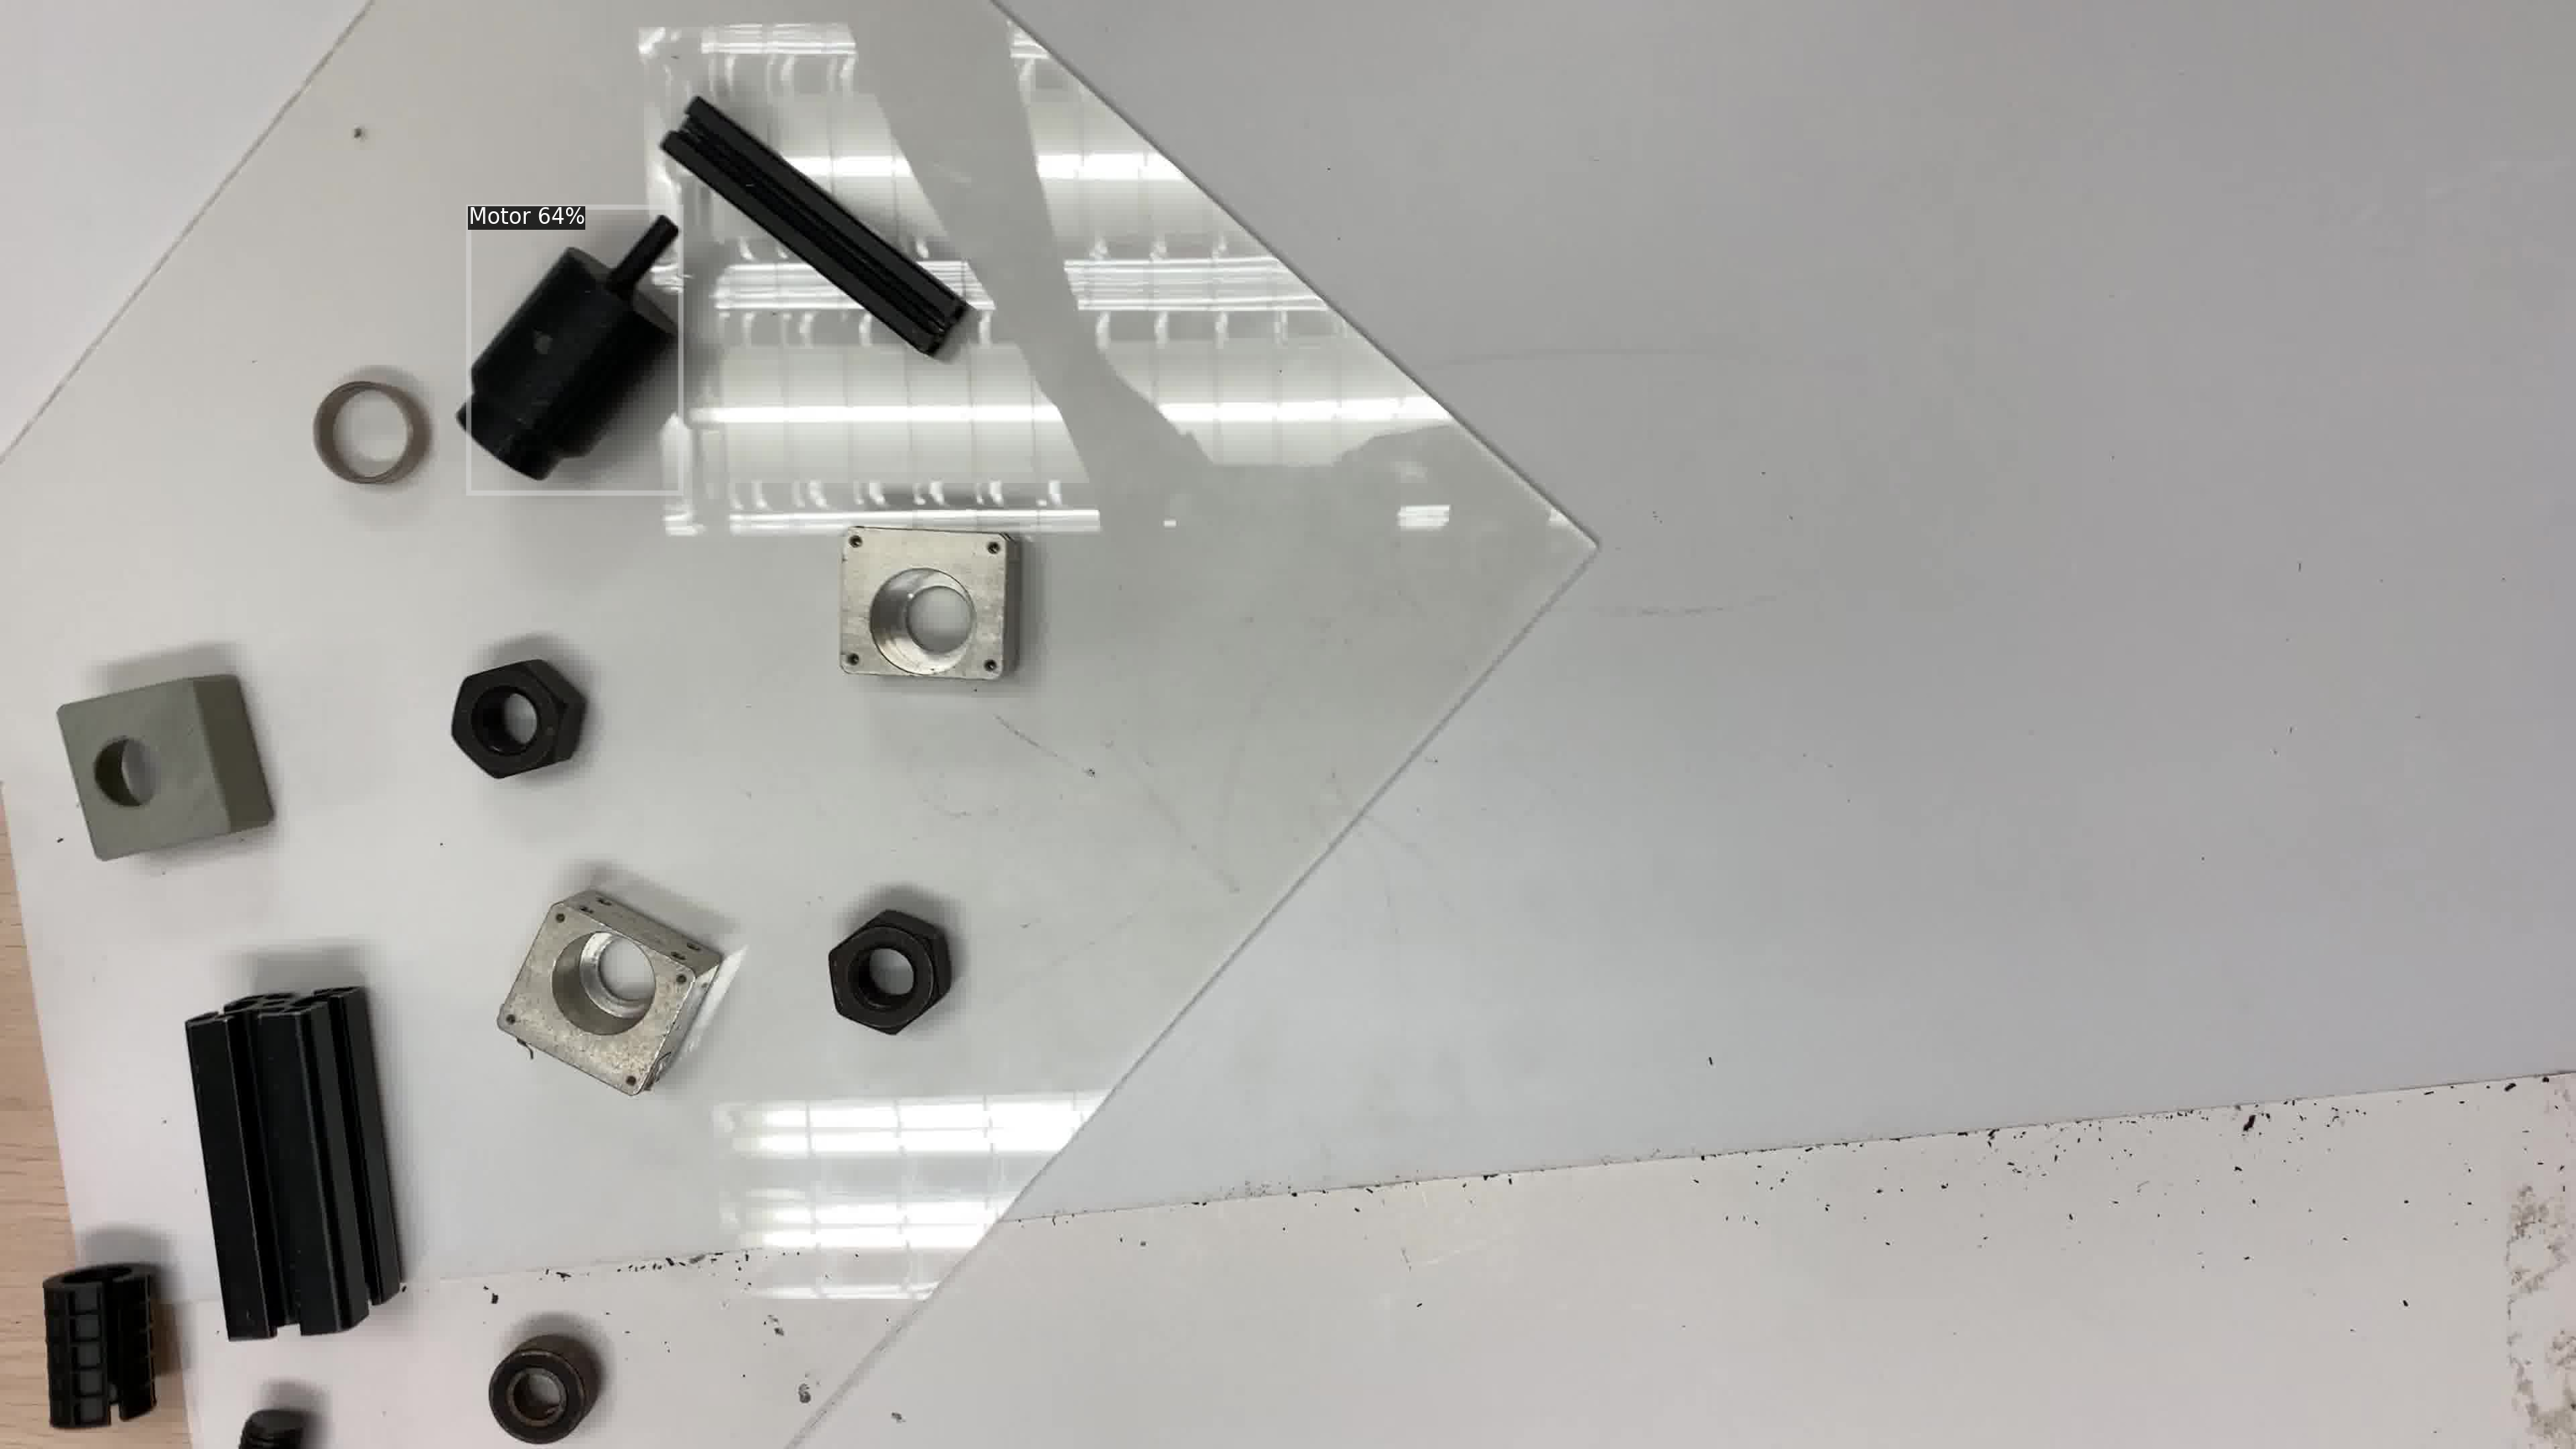

In [ ]:
for d in random.sample(test_dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_tools_metadata, 
                   scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("test_tools", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "test_tools")

inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [11/10 03:45:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/10 03:45:03 d2.data.datasets.coco]: Loaded 801 images in COCO format from coco_validate/labels.json
[11/10 03:45:03 d2.data.common]: Serializing 801 elements to byte tensors and concatenating them all ...
[11/10 03:45:03 d2.data.common]: Serialized dataset takes 0.47 MiB
[11/10 03:45:03 d2.evaluation.evaluator]: Start inference on 801 images
[11/10 03:45:13 d2.evaluation.evaluator]: Inference done 11/801. 0.7488 s / img. ETA=0:09:53
[11/10 03:45:18 d2.evaluation.evaluator]: Inference done 18/801. 0.7500 s / img. ETA=0:09:49
[11/10 03:45:23 d2.evaluation.evaluator]: Inference done 25/801. 0.7495 s / img. ETA=0:09:43
[11/10 03:45:29 d2.evaluation.evaluator]: Inference done 32/801. 0.7505 s / img. ETA=0:09:39
[11/10 03:45:34 d2.evaluation.evaluator]: Inference done 39/801. 0.7506 s / img. ETA=0:09:34
[11/10 03:45:39 d2.evaluation.evaluator]: Inferen

OrderedDict([('bbox',
              {'AP': 14.22336977653792,
               'AP-Axis': 18.76200421307492,
               'AP-Bearing': 27.406325990346303,
               'AP-Bearing_Box': 0.0,
               'AP-Defect': nan,
               'AP-Distance_Tube': 7.974556929427878,
               'AP-F20_20_B': 1.996083124795996,
               'AP-F20_20_G': 28.101472315880667,
               'AP-M20': 1.5019322559401074,
               'AP-M20_100': 26.053200325471902,
               'AP-M30': 6.9829511567284035,
               'AP-Motor': 30.46302383715903,
               'AP-R20': 6.357094605305691,
               'AP-S40_40_B': 1.7029702970297027,
               'AP-S40_40_G': 27.602192043832346,
               'AP50': 33.51130939381103,
               'AP75': 8.426371336036222,
               'APl': 12.726772998651237,
               'APm': 6.125622335603535,
               'APs': 0.0})])

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.84,fps:1.19
